# Libraries

In [1]:
#the usual
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt

#for FFT
import scipy
#for Signal Processing
import pywt

# Useful Functions

### Dealing With CSV

In [2]:
def remove_blank_lines(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Remove blank lines
    lines = [line for line in lines if line.strip()]
    
    with open(file_path, 'w', newline='') as file:
        file.writelines(lines)

### Data Viz

In [306]:
def plot_axes_vertical(df1,df2,time,para1,para2,para3,name1='Data1',name2='Data2',start=0,end=1000,scale=1):
    start = start*60
    end = end*60
    fig, axs = plt.subplots(3, 1, figsize=( 10 *scale, 8*scale))
    plt.rcParams['axes.grid'] = True
    axs[0].plot(df1[time][start:end], df1[para1][start:end], label=name1, color='blue')
    axs[0].plot(df2[time][start:end], df2[para1][start:end], label=name2,color='red')
    axs[0].set_ylabel(para1)
    axs[1].plot(df1[time][start:end], df1[para2][start:end], label=name1, color='blue')
    axs[1].plot(df2[time][start:end], df2[para2][start:end], label=name2, color='red')
    axs[1].set_ylabel(para2)
    axs[2].plot(df1[time][start:end], df1[para3][start:end], label=name1, color='blue')
    axs[2].plot(df2[time][start:end], df2[para3][start:end], label=name2, color='red')
    axs[2].set_ylabel(para3)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

In [4]:
def compare_plot_inrange(df1,df2,time,para1,para2,start,end,name1='Data1',name2='Data2'):
    plt.plot(df1[time][start:end], df1[para1][start:end], label=name1, color='green')
    plt.plot(df2[time][start:end], df2[para2][start:end], label=name2, color='red')
    plt.xlabel(time)
    if para1 == para2:
        plt.ylabel(para1)
    else:
        plt.ylabel(para1 + ' and ' + para2)
    plt.legend()

### Signal Processing

In [5]:
#Denosing the data in a dataframe using wavelet transform, the last 3 levels of the wavelet transform are set to zero to remove noise
def denoise_dataframe(df):
    #newdf = pd.DataFrame()
    #newdf.insert(len(newdf.columns), 'PacketCounter', df['PacketCounter'] ) 
    #newdf.insert(len(newdf.columns), 'SampleTimeFine', df['SampleTimeFine'] ) 
    #newdf['SampleTimeFine'] = df['SampleTimeFine']
    wavelet = 'db4'
    columns_to_include = ['Acc_X', 'Acc_Y', 'Acc_Z','Gyr_X', 'Gyr_Y', 'Gyr_Z']
    for column in df.columns:
        if column in columns_to_include:
            FPData = np.array(df[column]).astype('float32')
            DWTcoeffs = pywt.wavedec(FPData[:], wavelet)
            DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
            DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2]) 
            DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
            DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])
            #DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
            FPData_Decompos=pywt.waverec(DWTcoeffs,wavelet,mode='symmetric',axis=-1)
            if (len(FPData_Decompos) != len(FPData)):
                #print('Length of the decomposed signal is not equal to the original signal')
                FPData_Decompos = FPData_Decompos[0:len(FPData)]
            df[column] = FPData_Decompos
            df[column][0] = 0
            #newdf.insert( len(newdf.columns),column, FPData_Decompos )
    return df

In [6]:
#Remove DC Component of the Signal
# DC Component is the average of the signal over the time period, DC component in this case means there is a constant value added to the signal being 
# constant acceleration.
def remove_dc_component(df):
    columns_to_include = ['Acc_X', 'Acc_Y', 'Acc_Z']
    for column in df.columns:
        if column in columns_to_include:
            df[column][1:] = df[column][1:] - df[column][1:].mean()
            df[column][0] = 0
    return df

In [245]:
#FFT:Given a dataframe column, N being Sample Rate, F being Frequency of the signal, threshold being the threshold to ignore freq. below it for the FFT, and the plot_range to plot the FFT
#Compute FFT of the data and plot it
def plot_fft(df,pc,N=1000,F=800,threshold=200,plot_range=1000,scale=1,reconstruct=False):
    # sample spacing
    T = 1.0 / F
    yf = scipy.fftpack.fft(df.values)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    for i, value in enumerate(yf):
        if np.abs(value) < threshold:
            yf[i] = 0
    reconstructed = scipy.fftpack.ifft(yf)
    if reconstruct:
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10* 2 *scale , 10* scale))
        ax1.plot(xf[:plot_range], 2.0/N * np.abs(yf[:N//2])[:plot_range])
        ax2.plot(pc[:], reconstructed[:])
    else:
        fig,ax = plt.subplots(1,1,figsize=(10* 2 *scale , 10* scale))
        ax.plot(xf[:plot_range], 2.0/N * np.abs(yf[:N//2])[:plot_range])
    plt.show()
    return yf

In [8]:
def Compute_Velo(dfprime,paratobeadded,para2,sampling_rate=60):
    print("Computing " + paratobeadded + " based on " + para2)
    if paratobeadded not in dfprime.columns:
        dfprime.insert( len(dfprime.columns), paratobeadded,0)
        #dfprime[0,paratobeadded] = 0
        for i in range(1,len(dfprime[para2])):
            # Vn = Vn-1 + An * (1/sampling_rate) assuming V0 = 0 and A0 = 0
            AvgAcc = (dfprime[para2][i]+dfprime[para2][i-1])/2
            if abs(AvgAcc) < 0.01 :
                result = 0
            else:
                result = dfprime[paratobeadded][i-1] + dfprime[para2][i] * (1/sampling_rate) 
            (dfprime.loc[i,paratobeadded]) = round(  result ,6 )

In [9]:
#COMPUTE ALL VELOCITIES
mydict = {'Velo_X':'Acc_X','Velo_Y':'Acc_Y','Velo_Z':'Acc_Z'}
velolist = ['Velo_X','Velo_Y','Velo_Z']
def Compute_All_Velo(df):
    newdf = pd.DataFrame()
    newdf = df
    for item in velolist:
        if item not in newdf.columns:
            Compute_Velo(newdf,item,mydict[item],sampling_rate=60)
    return newdf

In [29]:
def Compute_Time_inSec(df):
    if 'Time' not in df.columns:
        df.insert( len(df.columns), 'Time',0)
        for i in range(1,len(df['PacketCounter'])):
            result = df['PacketCounter'][i] * (1/60)
            (df.loc[i,'Time']) = round(  result ,6 )
    return df

In [301]:
# Convert360 the angle data
# by default the angle data is in the range of -180 to 180, this function converts it to 0 to 360 range, 
# this is done by preserving the positive values, and adding 360 to the negative values
def convert360(column):
    for i, value in enumerate(column):
        if value < 0:
            column[i] = column[i] + 360

## COMBINE EVERYTHING FUNCTION

In [57]:
def read_all_csv_files_with_processing(mydirectory,savedir,threshold=0,save=False,removedc = False,denoise = False):
    mydf = {}
    for filename in os.listdir(mydirectory):
        if filename.endswith('.csv'):
            myname = filename.split('_')[0:1]
            file_path = os.path.join(mydirectory, filename)
            print("Reading File: " + filename)
            remove_blank_lines(file_path)
            df = pd.read_table(file_path,sep=',',skip_blank_lines=True,na_filter=True)
            df = df.dropna()
            df = Compute_Time_inSec(df)
            if "Unnamed: 11" in df.columns:
                df.drop("Unnamed: 11", axis=1, inplace=True)
            if removedc:
                df = remove_dc_component(df)
            if denoise:
                df = denoise_dataframe(df)
            print("Will Start Computing Velocities for " + myname[0])

            df = Compute_All_Velo(df)
            if save:
                print("Saving the File with Updated Velocities")
                if not os.path.exists(savedir):
                    os.makedirs(savedir)
                df.to_csv(savedir +  "\\" + myname[0] + "_with_all_velo" + ".csv", index=None, header=True)
            mydf[ myname[0] ] = df
    print (mydf.keys())
    return mydf

In [11]:
def read_ready_files(mydirectory):
    mydf = {}
    for filename in os.listdir(mydirectory):
        if filename.endswith('.csv'):
            myname = filename.split('_')[0:1]
            file_path = os.path.join(mydirectory, filename)
            print("Reading File: " + filename)
            df = pd.read_table(file_path,sep=',',skip_blank_lines=True,na_filter=True)
            mydf[ myname[0] ] = df
    print (mydf.keys())
    return mydf

# Analysis

## Directory

In [58]:
mydirectory = r'.\data\YJP'
savedir = os.path.join(mydirectory,'Processed')
savedir2 = os.path.join(mydirectory,'NOTPro')
readdir= r'.\data\YJP\DenoisedAccOnly'

## Velocity

In [59]:
mydf = read_all_csv_files_with_processing(mydirectory,savedir,threshold=0.01,denoise=True,removedc=True,save=True)
mydf.keys()

Reading File: Head2_D422CD00742D_20240318_112551.csv
Will Start Computing Velocities for Head2
Computing Velo_X based on Acc_X
Computing Velo_Y based on Acc_Y
Computing Velo_Z based on Acc_Z
Saving the File with Updated Velocities
Reading File: Head_D422CD008B5C_20240318_112551.csv
Will Start Computing Velocities for Head
Computing Velo_X based on Acc_X
Computing Velo_Y based on Acc_Y
Computing Velo_Z based on Acc_Z
Saving the File with Updated Velocities
Reading File: Left Foot2_D422CD0092B4_20240318_112551.csv
Will Start Computing Velocities for Left Foot2
Computing Velo_X based on Acc_X
Computing Velo_Y based on Acc_Y
Computing Velo_Z based on Acc_Z
Saving the File with Updated Velocities
Reading File: Left Foot_D422CD008B34_20240318_112551.csv
Will Start Computing Velocities for Left Foot
Computing Velo_X based on Acc_X
Computing Velo_Y based on Acc_Y
Computing Velo_Z based on Acc_Z
Saving the File with Updated Velocities
Reading File: Left Hand2_D422CD00936B_20240318_112551.csv
Wi

dict_keys(['Head2', 'Head', 'Left Foot2', 'Left Foot', 'Left Hand2', 'Left Hand', 'Right Foot2', 'Right Foot', 'Right Hand2', 'Right Hand'])

In [23]:
mydf = read_ready_files(readdir)

Reading File: Head2_with_all_velo.csv
Reading File: Head_with_all_velo.csv
Reading File: Left Foot2_with_all_velo.csv
Reading File: Left Foot_with_all_velo.csv
Reading File: Left Hand2_with_all_velo.csv
Reading File: Left Hand_with_all_velo.csv
Reading File: Right Foot2_with_all_velo.csv
Reading File: Right Foot_with_all_velo.csv
Reading File: Right Hand2_with_all_velo.csv
Reading File: Right Hand_with_all_velo.csv
dict_keys(['Head2', 'Head', 'Left Foot2', 'Left Foot', 'Left Hand2', 'Left Hand', 'Right Foot2', 'Right Foot', 'Right Hand2', 'Right Hand'])


In [60]:
df = mydf['Head']
df2 = mydf['Right Hand']
df3 = mydf['Left Hand']
df4 = mydf['Right Foot']    
df5 = mydf['Left Foot']

sdf = mydf['Head2']
sdf2 = mydf['Right Hand2']
sdf3 = mydf['Left Hand2']
sdf4 = mydf['Right Foot2']    
sdf5 = mydf['Left Foot2']

In [30]:
df2 = Compute_Time_inSec(df2)
sdf2 = Compute_Time_inSec(sdf2)

## Plots

In [15]:
sdf2['Velo_X'].mean()

-0.26066750470146527

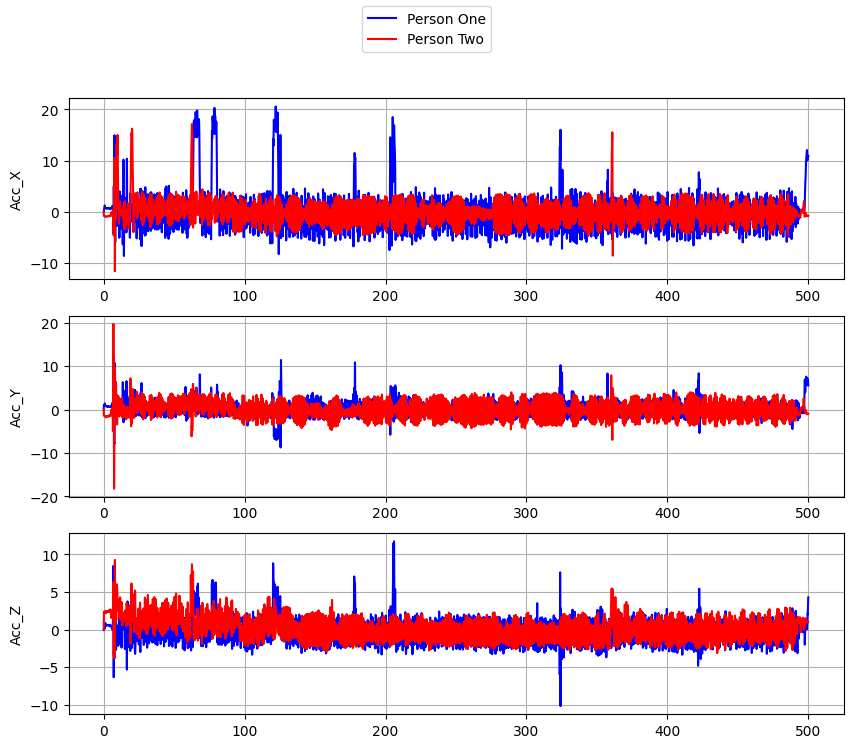

In [77]:
plot_axes_vertical(df2,sdf2,'Time','Acc_X','Acc_Y','Acc_Z',name1='Person One',name2='Person Two',start=000,end=30000)

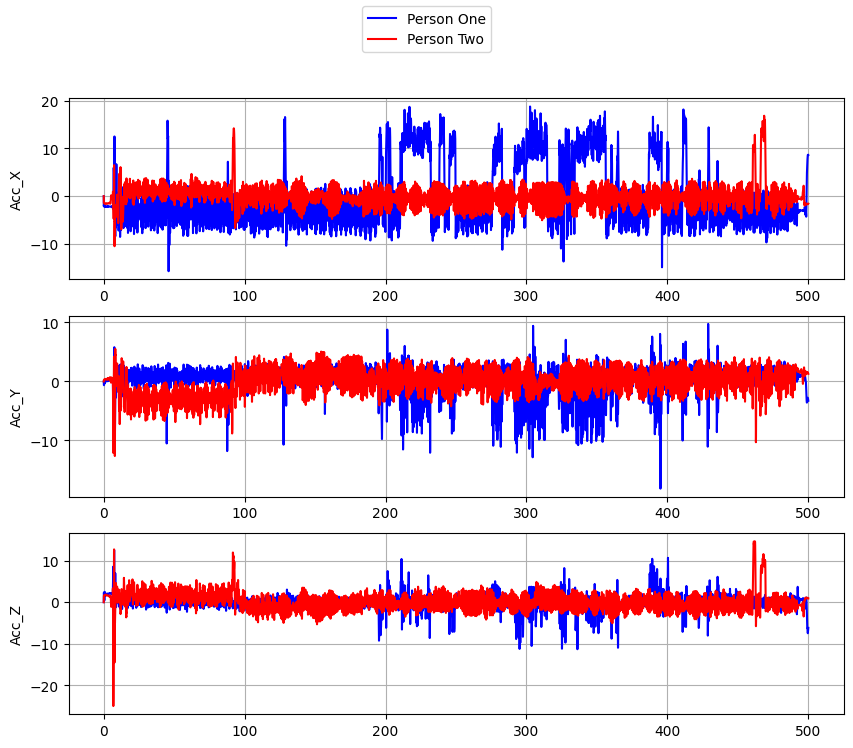

In [78]:
plot_axes_vertical(df3,sdf3,'Time','Acc_X','Acc_Y','Acc_Z',name1='Person One',name2='Person Two',start=0000,end=30000)

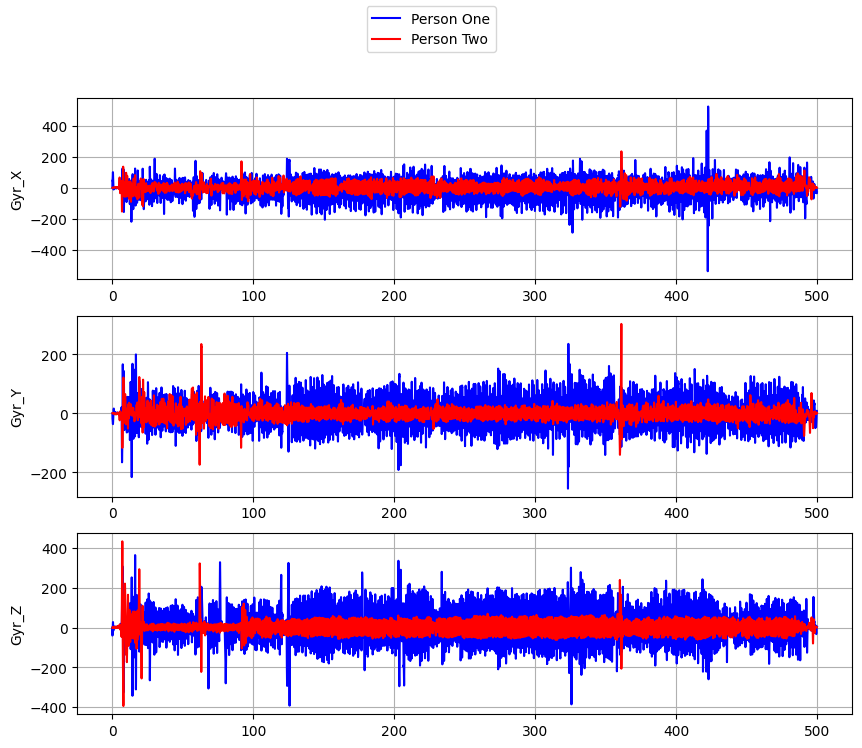

In [83]:
plot_axes_vertical(df2,sdf2,'Time','Gyr_X','Gyr_Y','Gyr_Z',name1='Person One',name2='Person Two',start=000,end=30000)

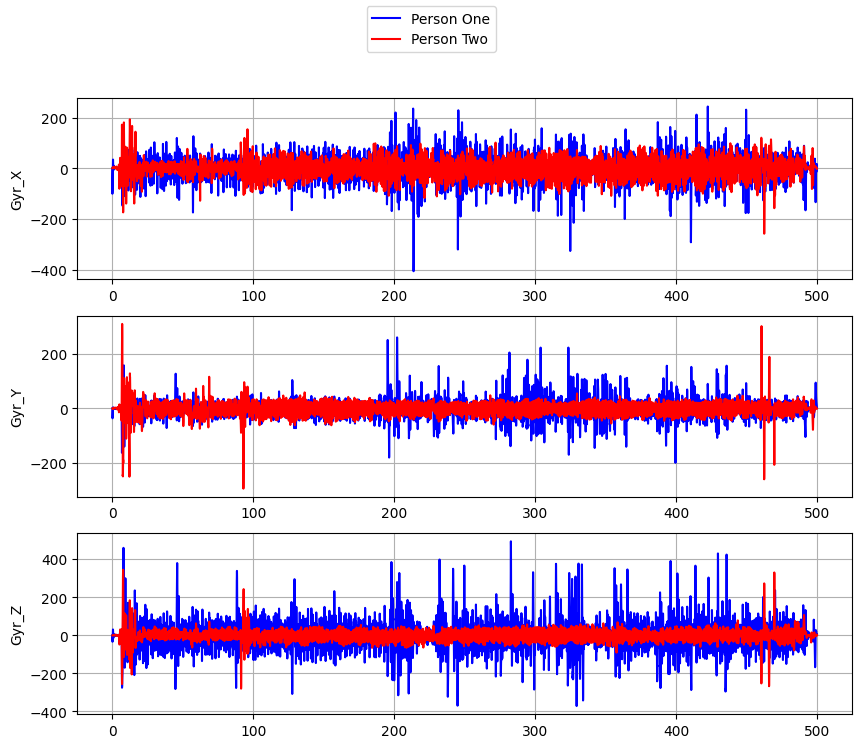

In [84]:
plot_axes_vertical(df3,sdf3,'Time','Gyr_X','Gyr_Y','Gyr_Z',name1='Person One',name2='Person Two',start=000,end=30000)

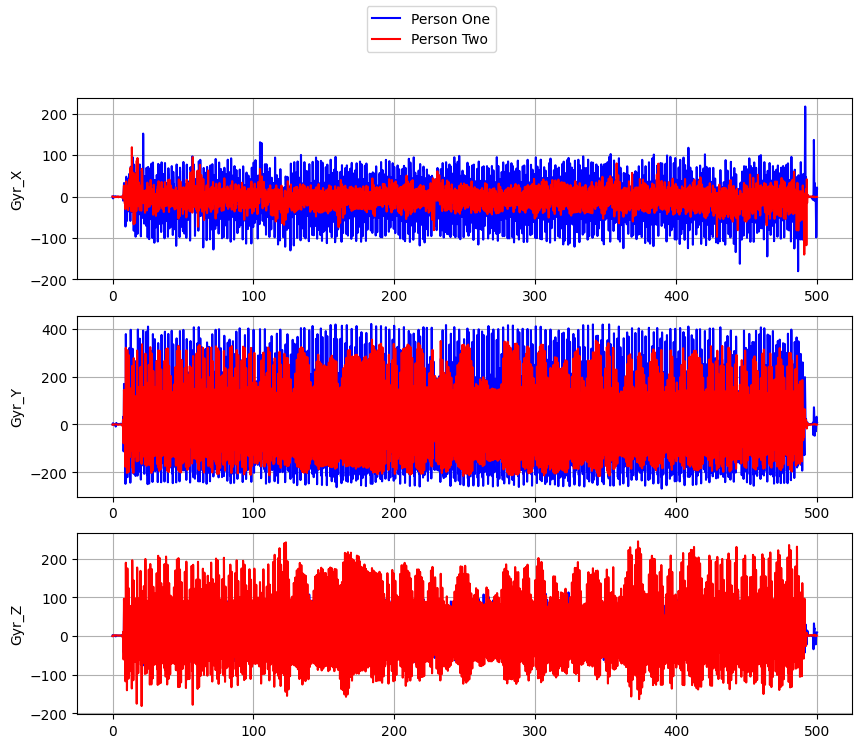

In [267]:
plot_axes_vertical(df4,sdf4,'Time','Gyr_X','Gyr_Y','Gyr_Z',name1='Person One',name2='Person Two',start=000,end=30000)

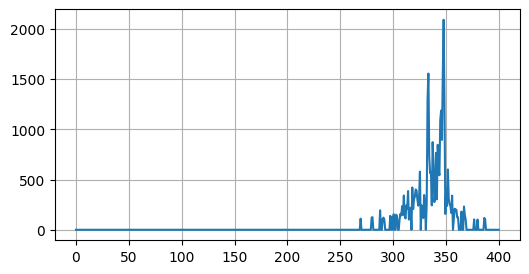

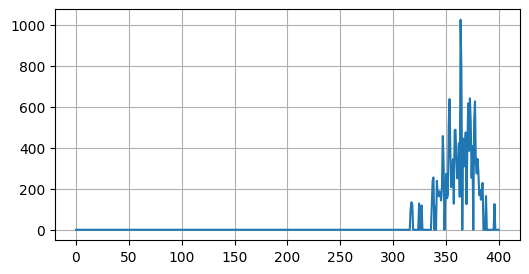

In [319]:
test1 = df4['Gyr_Y']
test2 = sdf5['Gyr_Y']
re1 = plot_fft(test1,df4['PacketCounter'],N=1000,F=800,threshold=50000,plot_range=1000,scale=0.3,reconstruct=False)
re2 = plot_fft(test2,sdf5['PacketCounter'],N=1000,F=800,threshold=50000,plot_range=1000,scale=0.3,reconstruct=False)

Mean = 0.024512299218371267 STD= 33.115847844259704 Max = 150.41741333333334 Min = -118.85872


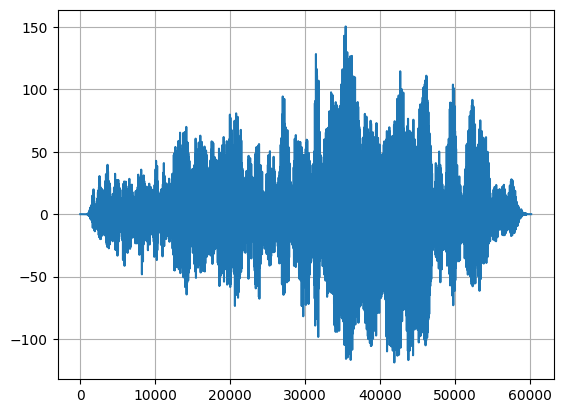

In [320]:
z = scipy.signal.correlate(test1,test2,method='fft') / 300000
print( 'Mean = ' + str(z.mean())+ ' STD= ' + str(z.std()) + ' Max = ' + str(z.max()) + ' Min = ' + str(z.min()) )
plt.plot(z)

Mean = (10.473067016908486-0.00010624611461952982j) STD= 162041.39885063664 Max = (2933161.984+1819943.4581333334j) Min = (-3232554.2434133333-1117842.1998933333j)


c:\Users\Majd\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Majd\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


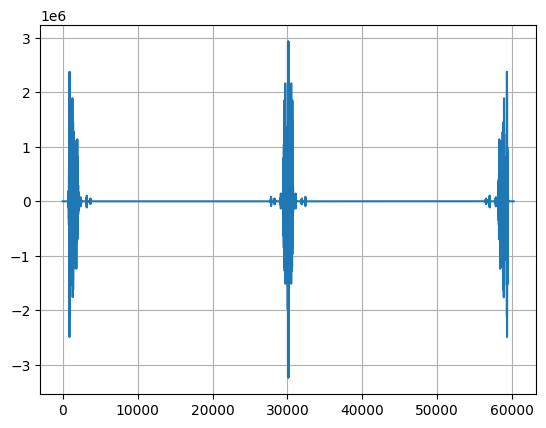

In [321]:
z = scipy.signal.correlate(re1,re2,method='fft') / 300000
print( 'Mean = ' + str(z.mean())+ ' STD= ' + str(z.std()) + ' Max = ' + str(z.max()) + ' Min = ' + str(z.min()) )
plt.plot(z)

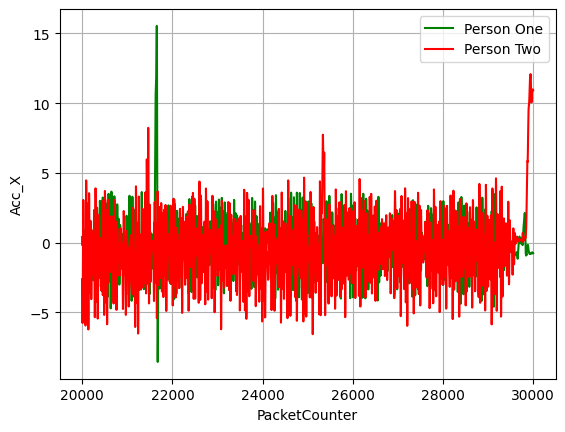

In [326]:
compare_plot_inrange(sdf2,df2,'PacketCounter','Acc_X','Acc_X',20000,30000,name1='Person One',name2='Person Two')

In [302]:
convert360(df['Euler_X'])
convert360(df['Euler_Z'])
convert360(sdf['Euler_X'])
convert360(sdf['Euler_Z'])

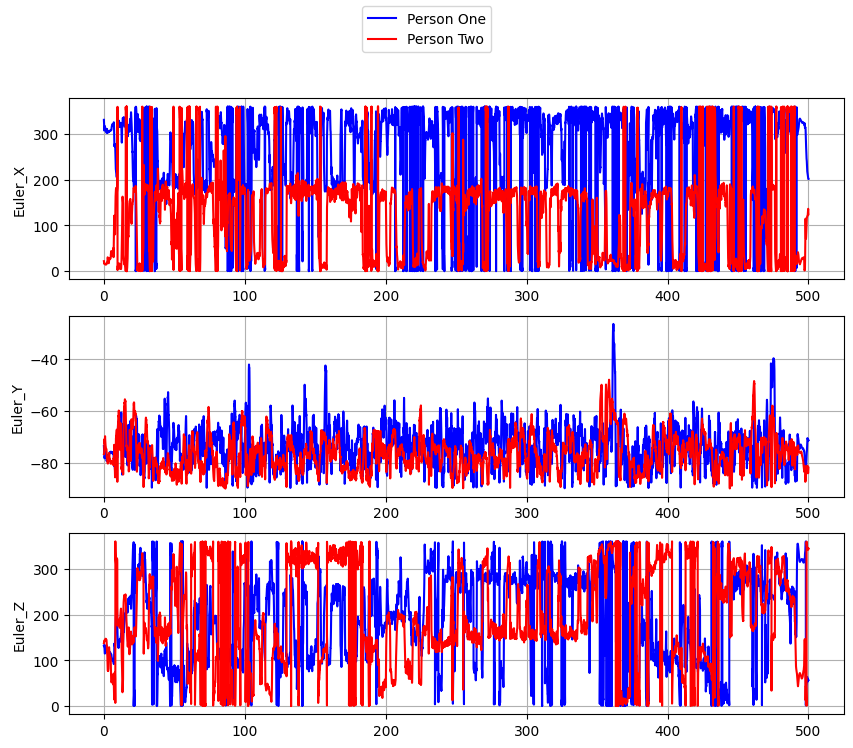

In [318]:
plot_axes_vertical(df,sdf,'Time','Euler_X','Euler_Y','Euler_Z',name1='Person One',name2='Person Two',start=0,end=500)